In [2]:
# imports/ helper functions
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize
pi=np.pi
pm = np.array((-1,1))
r2d,d2r = 180/pi,pi/180
r2d2,d2r2  = 90/pi,pi/90
ori_wrap = lambda x: SDF.wrap(x*2)/2

# modules from this package.
import SD_functions as SDF
import responseModel as RM

def sav_fig(nam):
    root = './Figs/'
    plt.savefig(root + nam +'.svg',dpi=1200)

# Load Data.
1- row per trial. Particiapnts concatenated vertically.


**Informative Columns:**
1. subject       - participant
1. trialProb     - validity of retro cue for given trial. 20- invalid, 50- neutral, 80- valid
1. correctAngle  - probed item orientation
1. distractAngle - non-probed item orientation
1. respAngle     - reported orientation
1. E             - wrap(respAngle-correctAngle)
1. RT            - response time. timed out at 5000ms
1. indProbed     - which item was probed (First, 0; or second, 1)

**Uninformative Columns:** taskVersion, cueType, grp, d, d_grp, grp_1

In [19]:
EV = pd.read_csv('data/task_events_local_v9.csv',index_col=0)
EV.head()

,subject,taskVersion,trialProb,cueType,correctAngle,distractAngle,respAngle,E,RT,indProbed,grp,d,d_grp,grp_1
0,UCSD072,local_v9,80.0,Number,-53.3122,-83.0642,74.00,-52.6878,5011.9410,1,-56.0,65.1473,56.0,11.0
1,UCSD072,local_v9,80.0,Number,-86.8577,31.8449,-0.55,86.3077,5011.7521,1,-79.0,33.5455,34.0,-56.0
2,UCSD072,local_v9,50.0,Number,44.3241,48.1176,-84.73,50.9459,5011.7829,1,34.0,48.8182,56.0,-79.0
3,UCSD072,local_v9,20.0,Number,14.5722,-70.5850,21.09,6.5178,5012.2209,0,11.0,29.7519,34.0,34.0
4,UCSD072,local_v9,80.0,Number,76.8696,80.6631,63.36,-13.5096,5000.0498,1,79.0,-62.2974,-56.0,11.0


In [81]:
n_trial = EV.groupby('subject').E.size().values
print(len(n_trial),np.min(n_trial),np.max(n_trial),np.mean(n_trial),np.std(n_trial)/np.sqrt(len(n_trial)-1))

18 192 488 380.0 15.195243493824023


In [31]:
np.mean(EV.trialProb==20)

0.16608187134502925

# Pooled Bias
Quickly visualize cardinal and serial bias for pooled trials across all subjects.

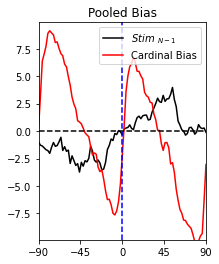

In [5]:
nb=-1
d_ori = SDF.get_nb(nb,EV['correctAngle'].values,1,ori_wrap) # dStim_nb

n_bns = 91
bns = np.linspace(-90,90,n_bns)
overlap = 3
this_sd = SDF.do_bining(bns,overlap,d_ori,EV['E']*d2r2,want_var='circ_mean')*r2d2
this_cb = SDF.do_bining(bns,overlap,EV.correctAngle,EV['E']*d2r2,want_var='circ_mean')*r2d2

plt.figure(figsize=(3,4))
# plt.plot(bns,this_sd)
plt.plot(bns,this_sd,'k',label='$Stim~_{N-1}$')
plt.plot(bns,this_cb,color='r',label='Cardinal Bias')
SDF.d_plot(1,9.9,-90)
plt.legend()
plt.title('Pooled Bias')
plt.show()

# Correct for history independent biases
- Note that to satistactorly fit these biases needed to use a 12 parameter Fourier function (rather than 6 parameter used in simulations)

0.6289244826203303
6840
18
21.471849918636636


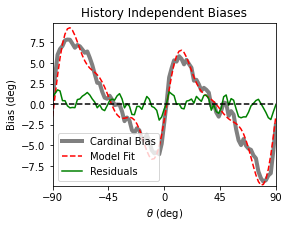

In [24]:
cEV=EV
stim = cEV['correctAngle'].values+90
resp = cEV['respAngle'].values+90
E = cEV['E'].values
subjs = cEV['subject'].values.astype(str)

# fit correction fun, can also try other fit functions here and vary the number of free parameters
# corr_fun, bias = RM.correct_cb(stim,resp,E,c_fun='sine',mode='fit_fun')
# corr_fun, bias = RM.correct_cb(stim,resp,E,c_fun='sawtooth',mode='fit_fun')
corr_fun, bias = RM.correct_cb(stim,resp,E,c_fun='fourier',n_param=12,mode='fit_fun')

plt.figure(figsize=(4,3))

plt.plot(bns,bias[0],color='gray',linewidth=4,label='Cardinal Bias')
plt.plot(bns,corr_fun(bns*d2r*2),'r--',label='Model Fit')
plt.plot(bns,bias[1],'g',label='Residuals')
plt.legend()

plt.title('History Independent Biases')
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('Bias (deg)')
SDF.d_plot(1,0,-90)
plt.ylim(-9.9,9.9)
# sav_fig('F7_emp_local_v9_hist_ind_bias')


print(SDF.circ_corr(stim*d2r*2,resp*d2r*2))
print(len(subjs))
print(len(np.unique(subjs)))
print(np.std(E))

# Response Analysis
Run history independent bias correction and compute stimulus, response, and joint biases for different reference trials.

In [88]:
nb_run = (-7,-5,-3,-2,-1,1,0)
nb_run = (-7,-6,-5,-4,-3,-2,-1,1,0)
# nb_run = (-2,-1,0)

n_trial = 360
n_subj = len(stim)//n_trial
do_boot = 1024 # 1024
if do_boot:
    n_subj = do_boot

# _,_resp,E_corrected = RM.correct_cb(stim,resp,E,c_fun='sawtooth',mode='E')#,subjs=subjs)#,n_subj=n_subj,n_trial=n_trial)
_,_resp,E_corrected = RM.correct_cb(stim,resp,E,c_fun='fourier',n_param=12,mode='E',subjs=subjs)#,n_subj=n_subj,n_trial=n_trial)

n_trial_total = len(E_corrected[0])
resp_stack = np.concatenate([_resp,_resp])
E_stack = np.stack([E[:n_trial_total],E_corrected[0]])
stats,bias_curve = RM.summarize_sim(stim[:n_trial_total],resp_stack,E_stack,n_subj=n_subj,n_trial=n_trial,nb_run=nb_run,
                       labs=('Raw','Corrected'),do_boot=do_boot,get_vis=1,subjs=subjs,subj_shuffle=1)


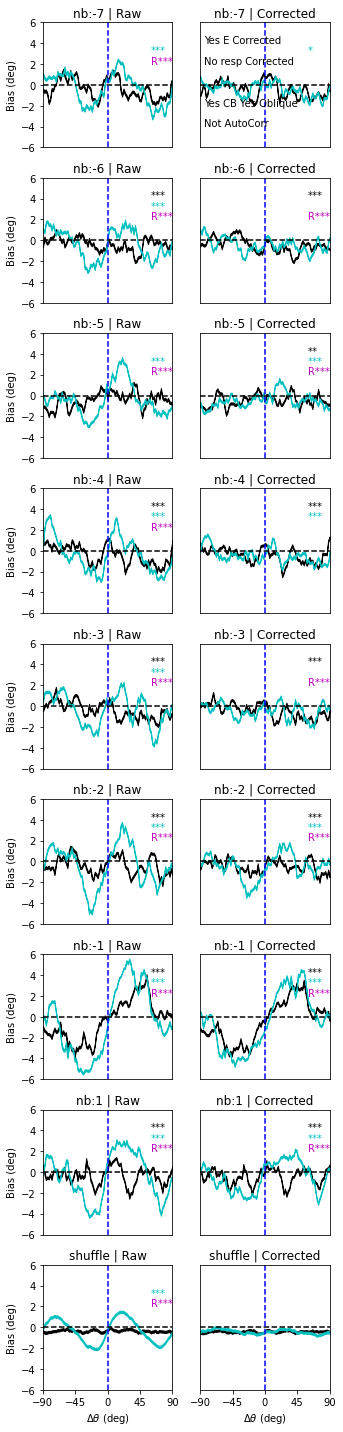

In [103]:
ann = (1,0,0,1,1)
nb_use = (-2,-1,0)
nb_use = nb_run
RM.vis_bias(bias_curve,nb_use,stats=stats,ann=ann,labs=('Raw','Corrected'),set_fs=(5,20),yl=6)
# sav_fig('F7_emp_local_v9_full_nb_1_squish')

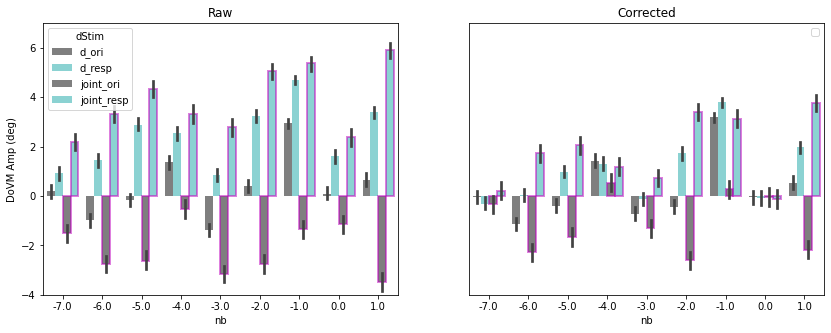

In [93]:
# htc = '///'
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
al = .5
yl = (-4,7)
bar = sns.barplot(data=stats[stats.trueSD=='Raw'],x='nb',y='amp',hue='dStim',ci=95,palette=['k','c'],alpha=al)
for i,thisbar in enumerate(bar.patches):
    if i>=(len(bar.patches)/2):
        thisbar.set_edgecolor('m')
        thisbar.set_linewidth(2)
#         thisbar.set_hatch(htc)
plt.ylabel('DoVM Amp (deg)')
plt.title('Raw')
plt.ylim(yl)
# plt.legend([])


plt.subplot(1,2,2)
bar = sns.barplot(data=stats[stats.trueSD=='Corrected'],x='nb',y='amp',hue='dStim',ci=95,palette=['k','c'],alpha=al)
for i,thisbar in enumerate(bar.patches):
    if i>=(len(bar.patches)/2):
        thisbar.set_edgecolor('m')
        thisbar.set_linewidth(2)
#         thisbar.set_hatch(htc)
plt.ylabel('DoVM Amp (deg)')
plt.title('Corrected')
plt.legend([])
plt.yticks([])
plt.ylabel('')
plt.ylim(yl)
# sav_fig('F7_emp_local_v9_bars_full_outline_fix')
plt.show()

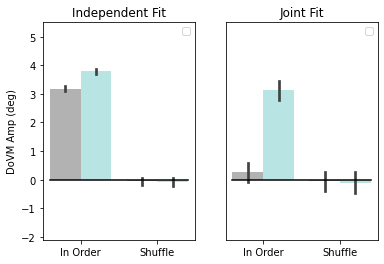

In [94]:
# sns.catplot(data=stats,x='nb',y='amp',hue='dStim',kind='bar',col='trueSD',ci=68)
# plt.title(this_task)
# # sav_fig('F7_emp_local_v9_bars_full')
# plt.show()
al=.3
yl = (-2.1,5.5)
plt.subplot(1,2,1)
sns.barplot(data=stats[(stats.trueSD=='Corrected')&(stats.nb>=-1)&(stats.nb<1)&np.isin(stats.dStim,('d_ori','d_resp'))],
            x='nb',y='amp',hue='dStim',palette=['k','c'],ci=68,alpha=al)
plt.ylim(yl)
plt.ylabel('DoVM Amp (deg)')
plt.xticks([0,1],['In Order','Shuffle'])
# plt.xlabel('Order')
plt.xlabel('')
plt.legend([])
plt.title('Independent Fit')
plt.plot([-.4,2.4-1],[0,0],'k')


plt.subplot(1,2,2)
bar = sns.barplot(data=stats[(stats.trueSD=='Corrected')&(stats.nb>=-1)&(stats.nb<1)&~np.isin(stats.dStim,('d_ori','d_resp'))],
            x='nb',y='amp',hue='dStim',palette=['k','c'],ci=95,alpha=al)

# for i,thisbar in enumerate(bar.patches):
#     thisbar.set_hatch(htc)
plt.ylim(yl)
plt.ylabel('')
plt.yticks([])
plt.xticks([0,1],['In Order','Shuffle'])
# plt.xlabel('Order')
plt.xlabel('')
plt.title('Joint Fit')
plt.plot([-.4,2.4-1],[0,0],'k')
plt.legend([])
# sav_fig('F7_emp_local_v9_bars_hatch_fix')
plt.show()

In [15]:
import scipy.stats
vals0 = (stats[(stats.trueSD=='Corrected')&(stats.nb==-1)&(stats.dStim=='d_ori')].amp.values,
        stats[(stats.trueSD=='Corrected')&(stats.nb==-1)&(stats.dStim=='d_resp')].amp.values)

vals1 = (stats[(stats.trueSD=='Corrected')&(stats.nb==-1)&(stats.dStim=='joint_ori')].amp.values,
        stats[(stats.trueSD=='Corrected')&(stats.nb==-1)&(stats.dStim=='joint_resp')].amp.values)

vals2 = (stats[(stats.trueSD=='Corrected')&(stats.nb==0)&(stats.dStim=='joint_ori')].amp.values,
        stats[(stats.trueSD=='Corrected')&(stats.nb==0)&(stats.dStim=='joint_resp')].amp.values)
scipy.stats.ttest_1samp(vals0[1],0)
scipy.stats.ttest_1samp(vals1[1],0)


Ttest_1sampResult(statistic=-0.10276478649728901, pvalue=0.9181697937882722)

In [17]:
scipy.stats.ttest_rel(vals1[0],vals1[1])

Ttest_relResult(statistic=-17.583978047704786, pvalue=1.115361202952566e-60)

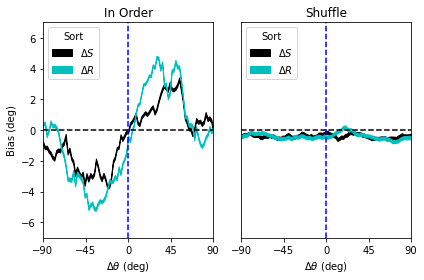

In [18]:
do_correction = 1


plt.figure(figsize=(6,4))
SDF.d_plot(1,9.9,-90)
for i in range(2):
    plt.subplot(1,2,i+1)
    SDF.sem_plot(bns,bias_curve[len(nb_run)-3+i*2,0,do_correction,],color='k',label='$\Delta S$')
    SDF.sem_plot(bns,bias_curve[len(nb_run)-3+i*2,1,do_correction,],color='c',label='$\Delta R$')
    SDF.d_plot(1,7,-90)
    foo = (1,'shuffle')[i]
    foo = ('In Order','Shuffle')[i]
    plt.title(f'{foo}')
    plt.xlabel('$\Delta\\theta$ (deg)')
    if i==0:
        plt.ylabel('Bias (deg)')
    else:
        plt.yticks([])
    plt.legend(title='Sort',loc=2)
plt.tight_layout()
# sav_fig('F7_emp_local_v9_cb_bias_curves')
plt.show()